# Calculations

## Surface Roughness Length

$$ z_{0} = \frac{(z_{2}-z_{1})}{[exp(\frac{kU_{2}}{u*}) - exp(\frac{kU_{1}}{u*})]} $$

Equation from {cite}`eol`

- $z_{0}$ is the roughness length
- $z_{1}$ height of $U_{1}$ ($2 m$)
- $z_{2}$ height of $U_{2}$ ($4 m$)
- $k$ is the Von Karmon constant ($0.4$)
- $u*$ is friction velocity (measured, in flux dataset)
- $U_{1}$ wind speed at $z_{1}$ (measued, in meteorology dataset)
- $U_{2}$ wind speed at $z_{2}$ (measued, in meteorology dataset)

In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import xarray as xr 
import numpy as np

import json
import time
import datetime
import glob

plt.style.use('default')


In [2]:
# Wind speed at 2 m
u1 = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_metData_v2.nc', 
                     decode_times = False)['wind_speed_2m'].mean().values

# Wind speed at 10 m
u2 = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_metData_v2.nc', 
                     decode_times = False)['wind_speed_10m'].mean().values

# Friction velocity
ustar = xr.open_dataset('/Users/smurphy/all_datasets/nice_published_datasets/N-ICE_sebData_v1.nc', 
                        decode_times = False)['friction_velocity'].mean().values

# Heights 
z1 = 2 # m
z2 = 10 # m

# Von Karmon Constant
k  = 0.4 

# Calculation
term1 = (z2 - z1)
term2 = np.exp((k * u2) / ustar)
term3 = np.exp((k * u1) / ustar)
z = term1 / (term2 - term3)

print('Surface Roughness Length (m):')
z

Surface Roughness Length (m):


0.0012378941216551337

We have roughness length from EddyPro, how does this match up to my calculated roughness length?

EddyPro calculates roughness length using the canopy height: $z_{0} = 0.15 * canopy\space height$, which is defined as $0$ in our EddyPro runs {cite}`eproman`.

In [3]:
roughness_length = pd.DataFrame(columns = ['Jan','Feb','Mar','Apr','May','Jun'])

for mon in ['Jan','Feb','Mar','Apr','May','Jun']:
    path = glob.glob('/Volumes/509_data/EddyPro/Output/EddyPro_Runs/FDCorrected_Output/20hz/' + mon + '/eddypro_sonic_essentials_*')
    mean_rl = pd.read_csv(path[0], 
                          index_col = 0)['roughness_length'].mean()
    roughness_length[mon] = [mean_rl]

roughness_length = roughness_length.T
roughness_length.columns = ['z']
print(roughness_length)

         z
Jan  0.001
Feb  0.001
Mar  0.001
Apr  0.001
May  0.001
Jun  0.001


So, I believe it's safe to say we can be confident in my roughness length calculations. 

---
## Surface Heat Capacity 

Sea Ice Thermodynamics {cite}`camdoc` equation 12

$$ c(T,S) = c_{0} + \frac{L_{i}\mu S}{T^{2}} $$

- $c(T,S)$ is the heat capacity, $\frac{J}{kg K}$
- $c_{0}$ is the heat capacity of fresh ice $2054 \frac{J}{kg K}$
- $L_{i}$ is the latent heat of fusion $3.340 * 10^{5} \frac{J}{kg}$
- $S$ is the salinity (we have salinity from the ice measurements) $\frac{g}{g}$
- $T$ is temperature (we have ice surface temperature from the ice measurements), $K$
- $\mu$ is the ocean freezing temperature constant and is directly related to salinity. Estimation: $0.054 \frac{^{\circ} C}{ppt}$ 

In [4]:
# Importing variables from the Sea Ice Physics dataset
# Sea ice salinity and surface temperature to be used in the surface heat capacity calculations
# Density to be used in this calculation for the thermal inertia constant

with open('/Users/smurphy/all_datasets/nice_published_datasets/n-ice2015-ice-core-physics.json') as f:
    data = json.load(f)
keys, vals = data.items()

density_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'density' in vals[1][i].keys():
        mean_level = (np.array(vals[1][i]['sample_top_cm'], dtype=np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype=np.float))] - np.array(vals[1][i]['sample_bottom_cm'], dtype=np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype=np.float))])/2
        den_vals = np.array(vals[1][i]['density'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['density'], dtype = np.float))]
        density_temp_df = pd.DataFrame(data = den_vals.reshape(1, len(den_vals)), 
                                       columns = mean_level,
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        density_df = pd.concat([density_df, density_temp_df], axis=1)
        
salinity_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'sea_ice_salinity' in vals[1][i].keys():
        den_vals = np.mean(np.array(vals[1][i]['sea_ice_salinity'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['sea_ice_salinity'], dtype = np.float))])
        salinity_temp_df = pd.DataFrame(data = [den_vals], 
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        salinity_df = pd.concat([salinity_df, salinity_temp_df], axis=1)
        
surft_df = pd.DataFrame()
for i in np.arange(0,len(vals[1]),1):
    if 'surface_temperature' in vals[1][i]['properties'].keys():
        den_vals = np.array(vals[1][i]['properties']['surface_temperature'], dtype = np.float)[~np.isnan(np.array(vals[1][i]['properties']['surface_temperature'], dtype = np.float))]
        surftemp_temp_df = pd.DataFrame(data = [den_vals], 
                                       index = [datetime.datetime.strptime(vals[1][i]['properties']['time'],"%Y-%m-%dT%H:%M:%SZ")])
        surft_df = pd.concat([surft_df, surftemp_temp_df], axis=1)
        
                
        

### What value of temperature should I use? 

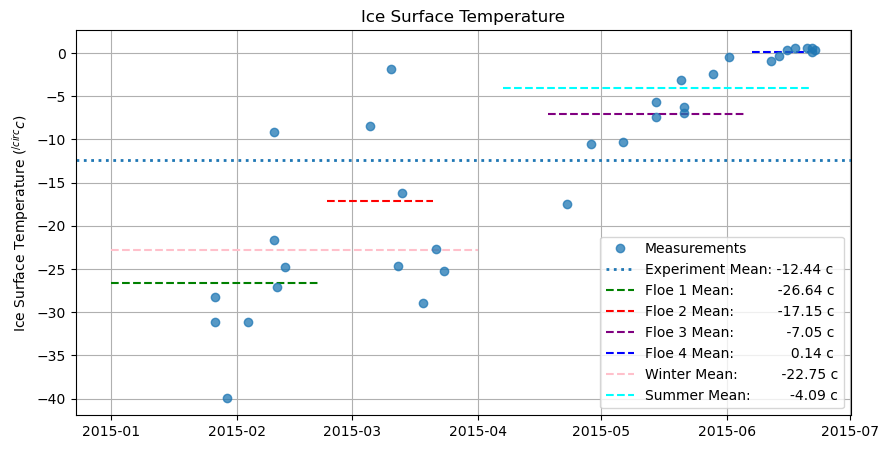

In [5]:
f1 = surft_df['2015-01-01':'2015-02-21']
f2 = surft_df['2015-02-23':'2015-03-21']
f3 = surft_df['2015-04-18':'2015-06-05']
f4 = surft_df['2015-06-07':'2015-06-21']

wint = surft_df['2015-01-01':'2015-04-01']
summ = surft_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(surft_df.mean(axis = 1), 'o', alpha = 0.75)

plt.axhline(surft_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Ice Surface Temperature $(^{/circ}c)$')
plt.title('Ice Surface Temperature')
plt.grid()
plt.legend(['Measurements', 'Experiment Mean: ' + str(np.round(surft_df.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 1 Mean:          ' + str(np.round(f1.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 3 Mean:            ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)) + ' c', 
            'Winter Mean:          ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' c', 
            'Summer Mean:         ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' c']);

In [6]:
print('Ice surface temperature (c)')
np.round(surft_df.mean(axis = 1).mean(),2)

Ice surface temperature (c)


-12.44

In [7]:
print('Winter surface temperature')
np.round(surft_df['2015-01-01':'2015-04-01'].mean(axis = 1).mean(),2)

Winter surface temperature


-22.75

In [8]:
print('Summer surface temperature')
np.round(surft_df['2015-04-07':'2015-06-21'].mean(axis = 1).mean(),2)

Summer surface temperature


-4.09

### How does this temperature compare to the surface temperature that Von calculated?

In [9]:
atmospheric_surface_temperature = pd.read_excel('/Users/smurphy/Documents/PhD/datasets/nice_data/Ts.xlsx', index_col = 0, parse_dates = True)

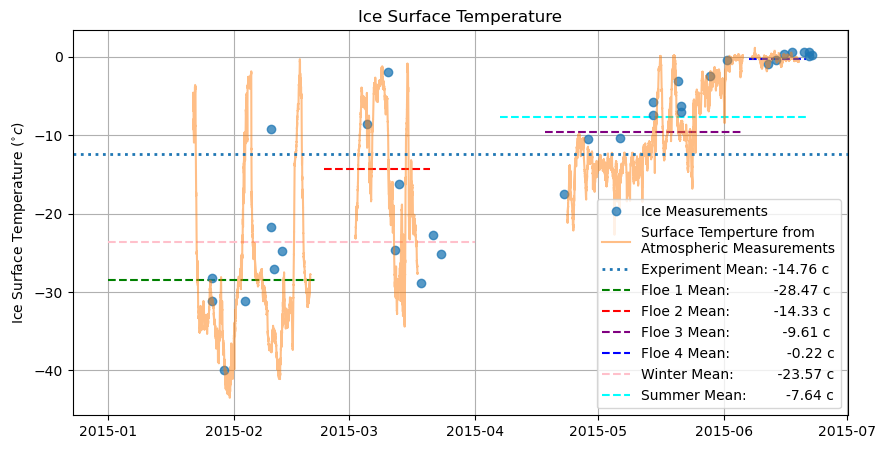

In [32]:
f1 = (atmospheric_surface_temperature - 273.15)['2015-01-01':'2015-02-21']
f2 = (atmospheric_surface_temperature - 273.15)['2015-02-23':'2015-03-21']
f3 = (atmospheric_surface_temperature - 273.15)['2015-04-18':'2015-06-05']
f4 = (atmospheric_surface_temperature - 273.15)['2015-06-07':'2015-06-21']

wint = (atmospheric_surface_temperature - 273.15)['2015-01-01':'2015-04-01']
summ = (atmospheric_surface_temperature - 273.15)['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(surft_df.mean(axis = 1), 'o', alpha = 0.75)
plt.plot(atmospheric_surface_temperature - 273.15, alpha=0.5)

plt.axhline(surft_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')


plt.ylabel('Ice Surface Temperature $(^{\circ}c)$')
plt.title('Ice Surface Temperature')
plt.grid()
plt.legend(['Ice Measurements', 
            'Surface Temperture from\nAtmospheric Measurements',
            'Experiment Mean: ' + str(np.round((atmospheric_surface_temperature - 273.15).mean()[0],2)) + ' c', 
            'Floe 1 Mean:          ' + str(np.round(f1.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 3 Mean:            ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' c', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)) + ' c', 
            'Winter Mean:          ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' c', 
            'Summer Mean:         ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' c',]);

The dashed line means in this figure represent means of the orange line

In [11]:
print('Winter surface temperature')
np.round((atmospheric_surface_temperature - 273.15)['2015-01-01':'2015-04-01'].mean(axis = 1).mean(),2)

Winter surface temperature


-23.57

In [12]:
print('Summer surface temperature')
np.round((atmospheric_surface_temperature - 273.15)['2015-04-07':'2015-06-21'].mean(axis = 1).mean(),2)

Summer surface temperature


-7.64

This doesn't change much, but I'll use our valaues of surface temperature for the calculations.

### What value of salinity should I use?

/Users/smurphy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


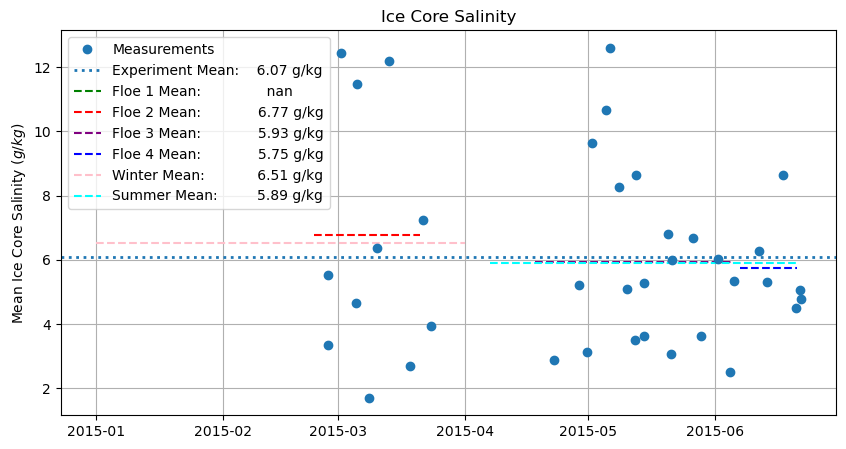

In [13]:

f1 = salinity_df['2015-01-01':'2015-02-21']
f2 = salinity_df['2015-02-23':'2015-03-21']
f3 = salinity_df['2015-04-18':'2015-06-05']
f4 = salinity_df['2015-06-07':'2015-06-21']

wint = salinity_df['2015-01-01':'2015-04-01']
summ = salinity_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(salinity_df.mean(axis = 1), 'o')
plt.axhline(salinity_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Mean Ice Core Salinity $(g/kg)$')
plt.title('Ice Core Salinity')
plt.grid()

plt.legend(['Measurements', 'Experiment Mean:    ' + str(np.round(salinity_df.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 1 Mean:               ' + str(np.round(f1.mean(axis = 1).mean(),2)), 
            'Floe 2 Mean:             ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 3 Mean:             ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)) + ' g/kg',
            'Winter Mean:            ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' g/kg', 
            'Summer Mean:         ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' g/kg'], loc = 'upper left');

In [14]:
print('Mean Ice Core Salinity: (g/kg)')
np.round(salinity_df.mean(axis = 1).mean(),2)

Mean Ice Core Salinity: (g/kg)


6.07

### Calculating 

Before we calculate this, let's remind ourselves of the equation:

$$ c(T,S) = c_{0} + \frac{L_{i}\mu S}{T^{2}} $$

- $c(T,S)$ is the heat capacity, $\frac{J}{kg K}$
- $c_{0}$ is the heat capacity of fresh ice $2054 \frac{J}{kg K}$
- $L_{i}$ is the latent heat of fusion $3.340 * 10^{5} \frac{J}{kg}$
- $S$ is the salinity (we have salinity from the ice measurements) $\frac{kg}{kg}$
- $T$ is temperature (we have ice surface temperature from the ice measurements), $K$
- $\mu$ is the ocean freezing temperature constant and is directly related to salinity. Estimation: $0.054 \frac{^{\circ} C}{ppt}$ 


In [15]:
#                                                                                    ** Desired units for each value
# Salinity
s = np.round(salinity_df.mean(axis = 1).mean(),2) # g / kg                           ** kg/kg
s = s / 1000 # kg / kg 

# Ocean freezing temperature constant    
mu = 0.054 # c / ppt                                                                 ** K 
mu = mu + 273.15 # K / ppt
#  I believe that ppt refers to the salinity
ppt = s * 10 ** 12  # ppt
mu = mu * ppt # k 

# Heat capacity of fresh ice
c0 = 2054 # J / (kg K)                                                               ** J/(kg K)

# Ice surface temperature
t = np.round(atmospheric_surface_temperature.mean(),2) # K                           ** K 

# Ice surface temperature - Summer
t_s = np.round(atmospheric_surface_temperature['2015-04-07':'2015-06-21'].mean(),2) # c    

# Ice surface temperature - Winter
t_w = np.round(atmospheric_surface_temperature['2015-01-01':'2015-04-01'].mean(),2) # c   

# Latent heat of fusion
li = 3.340 * 10 ** 5 # J / kg                                                        ** J/kg

# Calculating
c = c0 + ((li * mu * s) / (t**2))       # using mean temperature of entire experiment
c_w = c0 + ((li * mu * s) / (t_w**2))   # using mean winter temperature
c_s = c0 + ((li * mu * s) / (t_s**2))   # using mean summer/spring temperature

print('Surface Heat Capacity (J/(kg k)):')
print("{:e}".format(c[0]))

Surface Heat Capacity (J/(kg k)):
5.035696e+10


In [16]:
print('Winter Surface Heat Capacity (J/(kg k)):')
print("{:e}".format(c_w[0]))

Winter Surface Heat Capacity (J/(kg k)):
5.397484e+10


In [17]:
print('Summer Surface Heat Capacity (J/(kg k)):')
print("{:e}".format(c_s[0]))

Summer Surface Heat Capacity (J/(kg k)):
4.769240e+10


### Can we trust this calculation?
First, let's plot $\frac{L_{i}\mu S}{T^{2}}$ since this is the correction term.

#### Units?

$\frac{\frac{J}{kg}K \frac{kg}{kg}}{K^{2}} = \frac{\frac{J}{kg}}{K} $

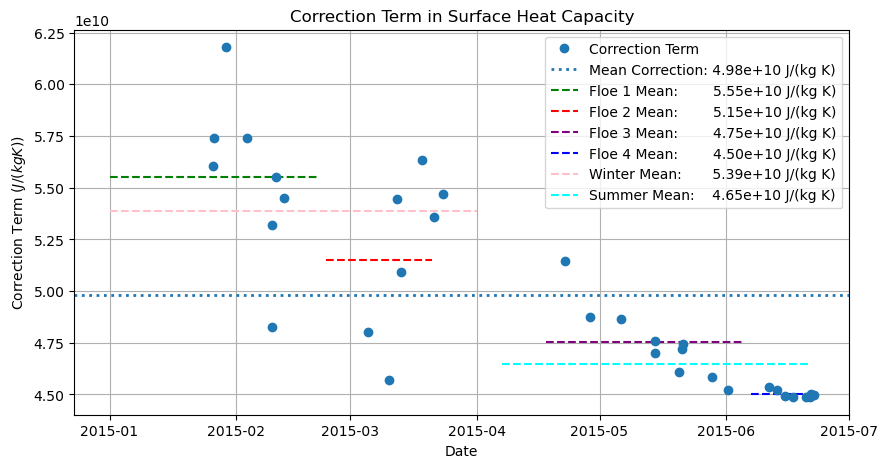

In [18]:
plt.figure(figsize = (10,5))

f1 = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-01-01':'2015-02-21']
f2 = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-02-23':'2015-03-21']
f3 = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-04-18':'2015-06-05']
f4 = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-06-07':'2015-06-21']

wint = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-01-01':'2015-04-01']
summ = c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-04-07':'2015-06-21']

plt.plot(c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)), 'o')
plt.axhline(c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.grid()
plt.title('Correction Term in Surface Heat Capacity')
plt.ylabel('Correction Term $(J/(kg \ K))$')
plt.xlabel('Date');

plt.legend(['Correction Term', 
            'Mean Correction: ' + "{:.2e}".format(c0 + ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)).mean()) + ' J/(kg K)',
            'Floe 1 Mean:        ' + "{:.2e}".format(f1.mean()) + ' J/(kg K)', 
            'Floe 2 Mean:        ' + "{:.2e}".format(f2.mean()) + ' J/(kg K)', 
            'Floe 3 Mean:        ' + "{:.2e}".format(f3.mean()) + ' J/(kg K)', 
            'Floe 4 Mean:        ' + "{:.2e}".format(f4.mean()) + ' J/(kg K)', 
            'Winter Mean:       ' + "{:.2e}".format(wint.mean()) + ' J/(kg K)', 
            'Summer Mean:    ' + "{:.2e}".format(summ.mean()) + ' J/(kg K)'],
           loc = 'upper right');


The value of $\mu$ is the determining factor for how large this value is

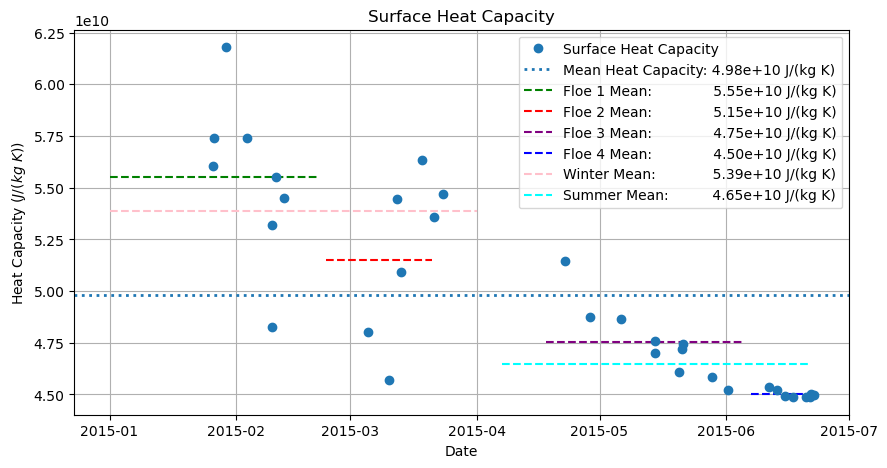

In [31]:
plt.figure(figsize = (10,5))

f1 = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-01-01':'2015-02-21']
f2 = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-02-23':'2015-03-21']
f3 = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-04-18':'2015-06-05']
f4 = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-06-07':'2015-06-21']

wint = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-01-01':'2015-04-01']
summ = ((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2))['2015-04-07':'2015-06-21']

plt.plot(((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)), 'o')
plt.axhline(((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.grid()
plt.title('Surface Heat Capacity')
plt.ylabel('Heat Capacity $(J/(kg \ K))$')
plt.xlabel('Date');

plt.legend(['Surface Heat Capacity', 
            'Mean Heat Capacity: ' + "{:.2e}".format(((li * mu * s) / ((surft_df.mean(axis = 1)+273.15)**2)).mean()) + ' J/(kg K)',
            'Floe 1 Mean:              ' + "{:.2e}".format(f1.mean()) + ' J/(kg K)', 
            'Floe 2 Mean:              ' + "{:.2e}".format(f2.mean()) + ' J/(kg K)', 
            'Floe 3 Mean:              ' + "{:.2e}".format(f3.mean()) + ' J/(kg K)', 
            'Floe 4 Mean:              ' + "{:.2e}".format(f4.mean()) + ' J/(kg K)', 
            'Winter Mean:             ' + "{:.2e}".format(wint.mean()) + ' J/(kg K)', 
            'Summer Mean:          ' + "{:.2e}".format(summ.mean()) + ' J/(kg K)'],
           loc = 'upper right');


The correction term is clearly dominating the surface heat capacity. To get it into the correct units, we need to multiply this by the ice density.

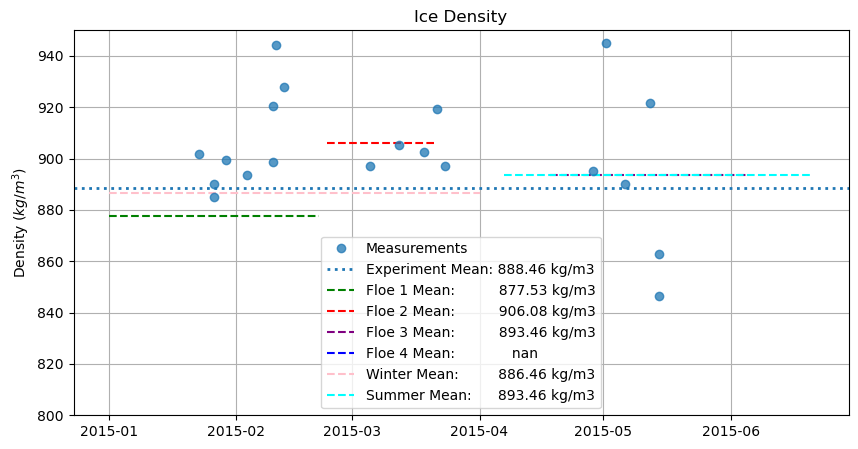

In [20]:
f1 = density_df['2015-01-01':'2015-02-21']
f2 = density_df['2015-02-23':'2015-03-21']
f3 = density_df['2015-04-18':'2015-06-05']
f4 = density_df['2015-06-07':'2015-06-21']

wint = density_df['2015-01-01':'2015-04-01']
summ = density_df['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(density_df.mean(axis = 1), 'o', alpha = 0.75)

plt.axhline(density_df.mean(axis = 1).mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(axis = 1).mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(axis = 1).mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(axis = 1).mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(axis = 1).mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(axis = 1).mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Density $(kg/m^{3})$')
plt.title('Ice Density')
plt.ylim(800, 950)
plt.grid()
plt.legend(['Measurements', 'Experiment Mean: ' + str(np.round(density_df.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 1 Mean:          ' + str(np.round(f1.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 3 Mean:          ' + str(np.round(f3.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Floe 4 Mean:             ' + str(np.round(f4.mean(axis = 1).mean(),2)),
            'Winter Mean:         ' + str(np.round(wint.mean(axis = 1).mean(),2)) + ' kg/m3', 
            'Summer Mean:      ' + str(np.round(summ.mean(axis = 1).mean(),2)) + ' kg/m3'], loc = 'lower center');

In [21]:
print('Ice density (kg/m3)')
np.round(density_df.mean(axis = 1).mean(),2)

Ice density (kg/m3)


888.46

In [22]:
c = c * density_df.mean(axis = 1).mean()   # J/(kg K) * kg/m3 = J/(m3 K)
c_w = c_w * density_df.mean(axis = 1).mean()   # J/(kg K) * kg/m3 = J/(m3 K)
c_s = c_s * density_df.mean(axis = 1).mean()   # J/(kg K) * kg/m3 = J/(m3 K)
print('Surface Heat Capacity (J/(m3 K))')
print("{:e}".format(c[0]))

Surface Heat Capacity (J/(m3 K))
4.474006e+13


In [23]:
print('Winter - Surface Heat Capacity (J/(m3 K))')
print("{:e}".format(c_w[0]))

Winter - Surface Heat Capacity (J/(m3 K))
4.795439e+13


In [24]:
print('Summer - Surface Heat Capacity (J/(m3 K))')
print("{:e}".format(c_s[0]))

Summer - Surface Heat Capacity (J/(m3 K))
4.237270e+13


## Albedo

What is the exact albedo throughout the experiment? We used a value of .8 for the simulations, but what is the actual value for each season? We have these measurements from N-ICE.

In [25]:
# Importing and formatting the albedo dataset
albedo_dataset = xr.open_dataset('/Users/smurphy/Documents/PhD/datasets/nice_data/N-ICE_albedoData_v1.nc')
albedo_dataframe = pd.DataFrame(columns = ['albedo', 'month', 'day'])
albedo_dataframe['albedo'] = albedo_dataset.surface_albedo_mean.values
albedo_dataframe['month'] = albedo_dataset.month.values
albedo_dataframe['day'] = albedo_dataset.day.values
albedo_dataframe.index = ['2015-0' + x + '-' for x in albedo_dataframe.month.values.astype(int).astype(str)] + albedo_dataframe['day'].dt.days.astype(str)
albedo_dataframe.index = pd.to_datetime(albedo_dataframe.index)
albedo_dataframe = albedo_dataframe['albedo']

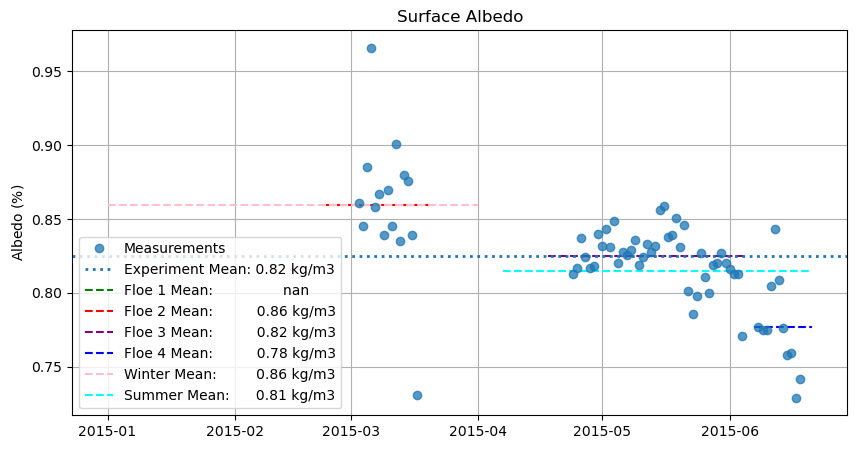

In [26]:
f1 = albedo_dataframe['2015-01-01':'2015-02-21']
f2 = albedo_dataframe['2015-02-23':'2015-03-21']
f3 = albedo_dataframe['2015-04-18':'2015-06-05']
f4 = albedo_dataframe['2015-06-07':'2015-06-21']

wint = albedo_dataframe['2015-01-01':'2015-04-01']
summ = albedo_dataframe['2015-04-07':'2015-06-21']

plt.figure(figsize = (10,5))
plt.plot(albedo_dataframe, 'o', alpha = 0.75)

plt.axhline(albedo_dataframe.mean(), linestyle = ':', linewidth = 2)

plt.hlines(f1.mean(), xmin = '2015-01-01', xmax = '2015-02-21', linestyle = '--', color = 'g')
plt.hlines(f2.mean(), xmin = '2015-02-23', xmax = '2015-03-21', linestyle = '--', color = 'r')
plt.hlines(f3.mean(), xmin = '2015-04-18', xmax = '2015-06-05', linestyle = '--', color = 'purple')
plt.hlines(f4.mean(), xmin = '2015-06-07', xmax = '2015-06-21', linestyle = '--', color = 'blue')

plt.hlines(wint.mean(), xmin = '2015-01-01', xmax = '2015-04-01', linestyle = '--', color = 'pink')
plt.hlines(summ.mean(), xmin = '2015-04-07', xmax = '2015-06-21', linestyle = '--', color = 'cyan')

plt.ylabel('Albedo $(\%)$')
plt.title('Surface Albedo')

plt.grid()
plt.legend(['Measurements', 'Experiment Mean: ' + str(np.round(albedo_dataframe.mean(),2)), 
            'Floe 1 Mean:                ' + str(np.round(f1.mean(),2)), 
            'Floe 2 Mean:          ' + str(np.round(f2.mean(),2)), 
            'Floe 3 Mean:          ' + str(np.round(f3.mean(),2)), 
            'Floe 4 Mean:          ' + str(np.round(f4.mean(),2)),
            'Winter Mean:         ' + str(np.round(wint.mean(),2)), 
            'Summer Mean:      ' + str(np.round(summ.mean(),2))], loc = 'lower left');

So we could increase the surface albedo to **0.86 in winter** and **0.81 in summer** 